Nesse notebook tem a discussao de 

In [1]:
import numpy as np
import time
from IPython.display import clear_output

In [2]:
from jupyterplot import ProgressPlot
import matplotlib.pyplot as plt

In [3]:
def alive_wealth_histogram(env):
    w = []
    for i in env.agents:
        w += [i.sugar]
    plt.hist(w,bins=20,density=True)
    plt.show()
    
    
def alive_age_histogram(env):
    w = []
    for i in env.agents:
        w += [i.steps_old/2]
    plt.hist(w,bins=20,density=True)
    plt.show()

In [18]:
class Simple_Agent:
    def __init__(self,environment,posx,posy):
        self.environment = environment
        self.posx = posx
        self.posy = posy
        
        # Caracteristicas
        self.life = np.random.normal(80, 5, None)
        self.sugar = 3
        self.vision = 2
        self.habilidade = 4 #precisa ser maior que metabolismo para que ocorra a acumulacao de capital
        self.metabolismo = 2
        self.step_no_job = 0
        
        # Historico
        self.total_balance = 0
        self.steps_old = 0
        self.children = []
        self.alive = True
    
    def get_vision(self):
        vision = np.zeros((2*self.vision+1,2*self.vision+1))
        i_vision =0
        j_vision =0
        for i in range(self.posx - self.vision, self.posx + self.vision + 1):
            for j in range(self.posy - self.vision, self.posy + self.vision + 1):
                vision[i_vision][j_vision] = self.environment.get_resource_square(i,j)
                j_vision += 1
            j_vision = 0
            i_vision+=1
        return vision
    
    def set_variables(self):
        new_vision = 2 + int(self.sugar/2)
        new_habilidade = 4 + int(self.sugar/2)
        if new_vision > self.environment.size/2:
            new_vision = int(self.environment.size/2)
        if new_habilidade > self.environment.max_produtivity:
            new_habilidade = self.environment.max_produtivity
        self.vision = new_vision
        self.habilidade = new_habilidade

    def move(self):
        
        vision = self.get_vision()
        x = 0
        y=0
        maior = 0
        # Caso Normal
        for i in range(-1,2):
            for j in range(-1,2):
                atual = vision[self.vision+i][self.vision+j]
                if atual > maior:
                    maior = atual
                    x = i
                    y = j
        if maior > 0:
            return x,y
                
        # Caso Heuristica
        x = 0
        y = 0
        cima = np.sum(vision[:self.vision + 1])
        baixo = np.sum(vision[self.vision:])
        if cima > baixo :
            y = -1
        elif cima<baixo:
            y = 1
            
        cima = np.sum(vision.transpose()[:self.vision + 1])
        baixo = np.sum(vision.transpose()[self.vision:])
        if cima > baixo :
            x = -1
        elif cima<baixo :
            x = 1
        
        if x == 0 and y ==0:
            #caso random
            x = np.random.random()*2 - 1
            x = int(x/abs(x))
            y = np.random.random()*2 - 1
            y = int(y/abs(y))
        return y,x
    
    def add_resource(self, qtd):
        self.sugar += qtd
    
    def life_step(self):
        self.steps_old +=1
        self.total_balance += self.sugar
        if self.sugar >= self.metabolismo:
            if self.sugar >= self.metabolismo*2:
                self.sugar -= self.metabolismo + self.habilidade*self.environment.MPC
            else:
                self.sugar -= self.metabolismo
            self.life -= 0.5
        else:
            self.environment.hungry_agents +=1 
            self.life -= 1.5
            
    def status(self):
        print("life ", np.round(self.life), "sugar", np.round(self.sugar))
            

In [19]:
def grid_rayleigh(size,mu,var):
    res = np.random.normal(mu,var,(size,size))
    res = res.clip(min=0)
    return res

In [20]:
def grid_random_mask(size,n_clusters,cluster_size):
    if cluster_size>size:
        return None
    res = np.zeros((size+2*cluster_size,size+2*cluster_size),dtype=np.int)
    cluster = np.ones((cluster_size,cluster_size),dtype=np.int)
    for i in range(n_clusters):
        x,y = np.random.randint(cluster_size,size+cluster_size,2)
        res[x:x+cluster_size,y:y+cluster_size] = cluster
    
    return res[cluster_size:cluster_size+size,cluster_size:cluster_size+size]

In [21]:
def grid_random_points_mask(size, n):
    res = np.zeros((size,size))
    random_points = np.random.randint(0,size,(n,2))
    for p in random_points:
        res[p[0]][p[1]] = 1
    return res

In [22]:
def get_variance_raylength(mu):
    return (mu**2)*(4-np.pi)/2

In [62]:
class Environment:
    def __init__(self,size,n_agents,step_for_resources = 5):
        self.size = size
        
        self.grid_players = np.zeros((size,size))
        self.grid_resources = np.zeros((size,size))
        self.step_for_resources = step_for_resources
        
        self.agents = []
        self.n_agents = n_agents
        self.dead_agents = []
        self.initial_sugar = 3
        
        self.birth_rate = 0.01
        
        self.cluster_n = 5
        self.cluster_size = 10
        self.cluster_renew_time = 5
        self.grid_production_mask = grid_random_mask(self.size,self.cluster_n,self.cluster_size)
        
        self.random_points_number = 50
        
        self.mean_sugar_production_per_square = 1
        self.max_production = 500
        self.variance_sugar_production_per_square = 1
        self.max_produtivity = self.mean_sugar_production_per_square + 3*self.variance_sugar_production_per_square
        self.sazonality_amplitude = 5
        self.sazonality_period = 5
        
        self.depreciation_percentage = 0.5 ## Warning, can be > 1
        self.depreciation = 1
        
        self.inheritance_tax = 0.8
        
        self.government_cost = 0.2
        self.government_efficiency =0.8
        
        self.MPC = 0.2 #Marginal Propensity To Consume
        
        
        #############################################
        ############### Log Variables ###############
        #############################################
        
        self.step_counter = 0
        
        self.government = 0
        
        self.sum_of_new_resources = 0
        self.available_resources = 0
        
        self.current_production = 0
        self.current_accumulation_capacity = 0

        
        self.hungry_agents = 0
        self.current_hunger_deaths = 0 
        
        self.agents_without_production =0
        
    def get_available_position_on_grid(self):
        pos = np.random.randint(self.size,size=2)
        while self.grid_players[pos[0]][pos[1]]==1:
            pos = np.random.randint(self.size,size=2)
        return pos
    
    def get_available_position_on_grid_next_to(self,posx,posy):
        i = 0
        minimo = 10
        x = posx
        y = posy
        while self.grid_players[posx][(posy + i)%self.size]==1:
            i+=1
        if i< minimo:
            minimo = i
            x = posx
            y = posy + i
            
            
        while self.grid_players[posx][(posy - i)%self.size]==1:
            i+=1
        if i< minimo:
            minimo = i
            x = posx
            y = posy - i
            
        while self.grid_players[(posx+i)%self.size][posy]==1:
            i+=1
        if i< minimo:
            minimo = i
            x = posx+i
            y = posy
            
        while self.grid_players[(posx - i)%self.size][posy]==1:
            i+=1
        if i< minimo:
            minimo = i
            x = posx -i
            y = posy
        return (x,y)
    

    def get_resource_square(self,x,y):
        return self.grid_resources[x%self.size][y%self.size]
    
    def init_simple_agent(self,sugar=None):
        if sugar == None:
            sugar = self.initial_sugar
        pos = self.get_available_position_on_grid()
        tmp = Simple_Agent(self,pos[0],pos[1])
        tmp.sugar = sugar
        self.agents += [tmp]
        return tmp
        
    def init_agents(self):
        for i in range(self.n_agents):
            self.init_simple_agent();
        
    def init_ordered_grid(self):
        for i in range(self.size):
            for j in range(self.size):
                self.grid_resources[i][j] = i*self.size + j
            
    def init_normal_random_grid(self,mu, var):
        for i in range(self.size):
            for j in range(self.size):
                tmp = np.random.normal(mu,var)//1
                if tmp > 0:
                    self.grid_resources[i][j] = tmp

    def mapa(self):
        mapa = np.zeros((self.size,self.size))
        for i in self.agents:
            mapa[i.posx][i.posy] = 1
        print(mapa)

    def resources(self):
        print(self.grid_resources)
        
    def pmapa(self):
        for i in range(self.size):
            for j in range(self.size):
                if self.grid_players[i][j] == 1:
                    print("(",int(self.grid_resources[i][j]),")\t", end= " ")
                else:
                    print(" ",int(self.grid_resources[i][j])," \t", end= " ")
            print("")
            f
            
    def grid_step(self):
        # Mask renew
        if self.step_counter%self.cluster_renew_time == 0:
            limite_inferior = self.cluster_n*self.cluster_size*self.cluster_size
            new = grid_random_mask(self.size,int(self.cluster_n/4),self.cluster_size)
            self.grid_production_mask = self.grid_production_mask - new
            self.grid_production_mask.clip(min=0)
            while np.sum(self.grid_production_mask)<limite_inferior*0.98:
                new = grid_random_mask(self.size,1,self.cluster_size)
                self.grid_production_mask +=new
                
                
        # Depreciation
        depreciation_n = int(self.depreciation_percentage*(self.size**2))
        self.grid_resources = self.grid_resources - self.depreciation*grid_random_points_mask(self.size,depreciation_n)
        self.grid_resources = self.grid_resources.clip(min=0)
        
        
        # Sazonality
        if(self.sazonality_amplitude >0):
            freq = 2*np.pi*self.step_counter/self.sazonality_period
            sazonal_sugar_production_mean = self.mean_sugar_production_per_square*(100 + self.sazonality_amplitude*np.sin(freq))/100
        else:
            sazonal_sugar_production_mean = self.mean_sugar_production_per_square
        
        # Adding resources
        full_harvest = grid_rayleigh(self.size, sazonal_sugar_production_mean,self.variance_sugar_production_per_square)
        if self.step_counter%self.step_for_resources==0:
            rnd_mask = np.logical_or(self.grid_production_mask,grid_random_points_mask(self.size,self.random_points_number))
            prod = full_harvest*rnd_mask
            while np.sum(prod)>self.max_production:
                depreciation_n = int(0.05*(self.size**2))
                prod = prod - prod*grid_random_points_mask(self.size,depreciation_n)
                
            self.grid_resources += prod
            self.sum_of_new_resources = np.sum(prod)
            self.available_resources = np.sum(self.grid_resources)
        else:    
            new_harvest = full_harvest*grid_random_points_mask(self.size,self.random_points_number)
            self.grid_resources += new_harvest
            self.sum_of_new_resources = np.sum(new_harvest)
            self.available_resources = np.sum(self.grid_resources)

        
#     def renew_grid(self):
#         #depreciacao
#         self.grid_resources = self.grid_resources*(1-self.depreciation)
#         self.grid_resources = self.grid_resources.clip(min=0)
            
#         new_resources = generate_sin_resource_grid(self.size,self.grid_counter/2)
#         soma_total = np.sum(new_resources)
        
#         while soma_total > self.max_sugar_production:
#             x = int(np.random.random()*self.size)
#             y = int(np.random.random()*self.size)
#             soma_total -= new_resources[x][y]
#             new_resources[x][y] = 0
            
#         #sazonalidade
#         new_resources = new_resources*(100 + self.sazonality_percentage*np.sin(self.grid_counter/4))/100
            
            
#         self.grid_counter += 1
#         print("total comida adicionados ", np.sum(new_resources), np.sum(self.grid_resources))
#         self.grid_resources += new_resources
        
    def gini(self):
        w = []
        for i in self.agents:
            w += [i.sugar]
        list.sort(w)

        curve = []
        total = 0

        base_length = 1/len(w)
        gini = 0

        for i in w:
            total += i
            gini += total*base_length


        gini = gini/total
        gini = (0.5 - gini)*2
        return gini
    
    def lorentz_curve(self):
        w = []
        for i in self.agents:
            w += [i.sugar]
        list.sort(w)

        curve = []
        total = 0

        base_length = 1/len(w)
        gini = 0
        for i in w:
            total += i
            gini += total*base_length
            curve += [total]
        curve = curve/total
        
        y = np.arange(0,1,1/len(curve))
        if len(y)> len(curve):
            y = y[0:-1]
            
        plt.plot(y,curve)
        plt.plot([0,np.max(curve)],[0,np.max(curve)])
        plt.show()

    def status_valores_absolutos(self):
        print("gdp: ",self.current_production)
        print("current_accumulation_capacity: ",self.current_accumulation_capacitycurrent_production_capacity) 
        
        
    def step(self):
        
        if len(self.agents)<=0:
            return

        
        
        
                
        #############################################
        ############### Log Variables ###############
        #############################################
        vivos = []
        self.hungry_agents = 0
        self.current_accumulation_capacitycurrent_production_capacity = 0
        self.current_hunger_deaths = 0
        self.current_production = 0
        self.agents_without_production = 0





        
        #Add Resources To Grid    
        self.grid_step()
        for agent in self.agents:
            
            # Move
            (x,y)  = agent.move()
            (px,py) = ((agent.posx + x)%self.size, (agent.posy + y)%self.size)

            if self.grid_players[px][py] != 1:
                self.grid_players[agent.posx][agent.posy] = 0
                agent.posx = px
                agent.posy = py
                self.grid_players[px][py] = 1
            
            
            
            # Get Resource
            r = self.grid_resources[agent.posx,agent.posy]
            self.current_accumulation_capacity += agent.habilidade - agent.metabolismo
            
            if r < agent.metabolismo:
                agent.step_no_job += 1
                if agent.step_no_job>7 or agent.sugar<agent.metabolismo:
                    self.agents_without_production += 1
            else:
                agent.step_no_job = 0

            if r > agent.habilidade:
                self.current_production += agent.habilidade
                agent.add_resource(agent.habilidade)
                self.grid_resources[agent.posx,agent.posy] -=agent.habilidade
            else:
                self.current_production += r
                agent.add_resource(r)
                self.grid_resources[agent.posx,agent.posy] = 0
            
            agent.set_variables()
            
            # Welfare
            if agent.sugar < agent.metabolismo and self.government > 0 and agent.life > 40:
                t = agent.metabolismo - agent.sugar
                self.government -= t
                agent.sugar += t
                agent.visao = 5
                
                
                
            # Life step
            agent.life_step()
            
            if np.random.random()<self.birth_rate:
                self.get_available_position_on_grid_next_to(agent.posx,agent.posy)
                child = self.init_simple_agent()
                agent.children += [child]
                agent.sugar = agent.sugar
            
                
            
             #Death Time
            if agent.life >0:
                vivos += [agent]
            else:                
                if len(agent.children)>0:
                    if agent.sugar > 4:
                        tax = agent.sugar*self.inheritance_tax
                    else: 
                        tax = 0
                    self.government += tax
                    agent.sugar -= tax
                    
                    
                    heirs = []
                    heirs_to_check = agent.children
                    
                    while len(heirs_to_check)>0:
                        c = heirs_to_check.pop()
                        if c.alive:
                            heirs += [c]
                        else:
                            heirs_to_check += c.children
                    inheritance = agent.sugar/len(heirs)
                    for c in heirs:
                        c.sugar += inheritance
                else:
                    self.government += agent.sugar
                if agent.sugar < 2:
                    self.current_hunger_deaths += 1
                self.dead_agents += [agent]
                agent.alive = False
                self.grid_players[agent.posx][agent.posy] = 0            
        #Add live agents 
        self.agents = vivos
        
#         # Add new Agents
#         while len(self.agents)<self.n_agents:
#             self.init_simple_agent()
        
        self.step_counter += 1
print("ok")

ok


In [55]:

size = 30
a = Environment(size,100)
a.init_agents()

a.birth_rate = 0.009

a.step_for_resources = 1

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 4

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 2
a.variance_sugar_production_per_square = 3
a.max_produtivity = 20
a.sazonality_amplitude = 0
a.sazonality_period = 40
a.depreciation = 0.5
a.depreciation_percentage = 0.5


a.inheritance_tax = 0

a.MPC = 0

a.step()



## Evolução dos agregados
print_step = 1
pp = ProgressPlot(line_names=["agents", "+sugar","poverty","GDP","Gini","unemployment"])
# pp = ProgressPlot(line_names=["+sugar","GDP","unemployment","total sugar"])  

c_agents =0
c_production = 0
c_current_accumulation_capacity = 0
c_gini = 0
c_resouces = 0
c_hungry_agents = 0
c_current_hunger_deaths = 0
c_agents_without_production = 0
c_available_resources = 0

gini_total = []
for i in range(2000):
    c_agents +=len(a.agents)
    c_current_accumulation_capacity += a.current_accumulation_capacity
    c_gini += a.gini()
    gini_total += [a.gini()]
    c_hungry_agents += a.hungry_agents
    c_current_hunger_deaths += a.current_hunger_deaths
    
    c_resouces += a.sum_of_new_resources
    c_available_resources += a.available_resources
    c_production += a.current_production
    c_agents_without_production += a.agents_without_production
    if i%print_step == 0:
        c_agents = (1/1)*c_agents/print_step
        c_agents_without_production = (1/1)*c_agents_without_production/print_step
        c_hungry_agents =(1/1)*c_hungry_agents/print_step
        c_gini = (1000)*c_gini/print_step

        
        c_current_accumulation_capacity = (1/100)*(c_current_accumulation_capacity/(print_step))
        c_resouces = (1/10)*(c_resouces/(print_step*2))
        c_production = (c_production/(print_step))/2
        c_available_resources = (1/10)*c_available_resources/(print_step)

        c_current_hunger_deaths = c_current_hunger_deaths/print_step
        
        
        ##População
        pp.update([[c_agents,c_resouces,c_hungry_agents,c_production,c_gini,c_agents_without_production]])
        
        ##Producao
#         pp.update([[c_resouces,c_production,c_agents_without_production,c_available_resources]])

        print(c_agents)
            
            
        c_agents = 0
        c_production = 0
        c_current_accumulation_capacity = 0
        c_gini = 0
        c_resouces = 0
        c_hungry_agents = 0
        c_current_hunger_deaths = 0
        c_agents_without_production = 0
        c_available_resources = 0
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)







100.0
101.0
101.0
101.0
106.0
107.0
108.0
108.0
110.0
112.0
116.0
118.0
119.0
119.0
121.0
122.0
123.0
125.0
126.0
128.0
129.0
130.0
130.0
130.0
131.0
133.0
134.0
137.0
138.0
140.0
140.0
142.0
144.0
145.0
145.0
146.0
147.0
150.0
154.0
156.0
157.0
161.0
161.0
164.0
165.0
167.0
169.0
172.0
173.0
176.0
177.0
177.0
180.0
182.0
183.0
185.0
187.0
189.0
190.0
194.0
195.0
196.0
200.0
201.0
205.0
208.0
210.0
213.0
215.0
216.0
218.0
221.0
224.0
227.0
230.0
230.0
232.0
235.0
235.0
237.0
238.0
241.0
244.0
246.0
246.0
246.0
247.0
248.0
251.0
255.0
258.0
260.0
262.0
265.0
267.0
267.0
270.0
270.0
271.0
274.0
276.0
278.0
279.0
282.0
285.0
286.0
290.0
293.0
296.0
297.0
302.0
304.0
309.0
313.0
318.0
321.0
322.0
324.0
328.0
328.0
328.0
332.0
334.0
336.0
340.0
343.0
346.0
350.0
352.0
356.0
358.0
357.0
357.0
362.0
364.0
365.0
363.0
363.0
367.0
367.0
365.0
365.0
362.0


/Users/kauemoraes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:368: RuntimeWarning: divide by zero encountered in double_scalars


364.0
364.0
358.0
357.0
352.0
351.0
350.0
345.0
343.0
338.0
332.0
332.0
333.0
326.0
324.0
313.0
304.0
299.0
301.0
296.0
289.0
289.0
284.0
282.0
280.0
279.0
274.0
274.0
275.0
272.0
272.0
273.0
272.0
274.0
271.0
272.0
271.0
270.0
269.0
270.0
271.0
269.0
270.0
269.0
267.0
264.0
270.0
271.0
267.0
265.0
267.0
269.0
267.0
272.0
274.0
276.0
278.0
281.0
280.0
282.0
279.0
279.0
281.0
287.0
288.0
290.0
290.0
292.0
297.0
298.0
300.0
306.0
307.0
308.0
313.0
313.0
318.0
317.0
320.0
323.0
325.0
328.0
330.0
334.0
335.0
339.0
344.0
347.0
347.0
348.0
350.0
352.0
355.0
356.0
358.0
360.0
363.0
365.0
366.0
366.0
366.0
369.0
372.0
371.0
375.0
374.0
377.0
383.0
381.0
382.0
383.0
385.0
386.0
389.0
390.0
390.0
390.0
394.0
395.0
395.0
394.0
396.0
396.0
398.0
402.0
399.0
396.0
392.0
391.0
389.0
385.0
385.0
381.0
383.0
380.0
379.0
375.0
369.0
369.0
367.0
371.0
368.0
368.0
370.0
371.0
376.0
376.0
373.0
369.0
369.0
366.0
363.0
366.0
366.0
363.0
360.0
361.0
361.0
359.0
356.0
350.0
348.0
345.0
341.0
339.0
334.0
332.

321.0
321.0
320.0
317.0
315.0
315.0
313.0
315.0
313.0
310.0
309.0
308.0
311.0
312.0
313.0
313.0
315.0
313.0
315.0
315.0
314.0
315.0
314.0
315.0
313.0
316.0
317.0
319.0
319.0
322.0
321.0
320.0
320.0
318.0
316.0
315.0
315.0
317.0
317.0
318.0
315.0
313.0
306.0
306.0
306.0
307.0
306.0
305.0
305.0
305.0
302.0
303.0
299.0
298.0
295.0
293.0
289.0
286.0
283.0
283.0
281.0
281.0
281.0
282.0
283.0
283.0
284.0
281.0
281.0
281.0
283.0
283.0
283.0
286.0
283.0
283.0
282.0
280.0
283.0
287.0
288.0
284.0
285.0
286.0
283.0
284.0
286.0
282.0
284.0
278.0
277.0
274.0
279.0
277.0
279.0
279.0
279.0
277.0
278.0
276.0
272.0
274.0
275.0
277.0
277.0
277.0
277.0
274.0
275.0
277.0
277.0
276.0
279.0
277.0
275.0
274.0
273.0
273.0
272.0
276.0
281.0
288.0
288.0
289.0
288.0
285.0
286.0
286.0
291.0
290.0
291.0
291.0
289.0
296.0
293.0
294.0
294.0
292.0
294.0
295.0
298.0
297.0
304.0
306.0
305.0
309.0
312.0
312.0
310.0
312.0
311.0
308.0
309.0
311.0
313.0
311.0
313.0
312.0
313.0
314.0
314.0
315.0
315.0
312.0
315.0
317.0
312.

In [56]:
np.mean(gini_total[500:2000]),np.var(gini_total[500:2000])

(0.70287415141617782, 0.00062899591055460321)

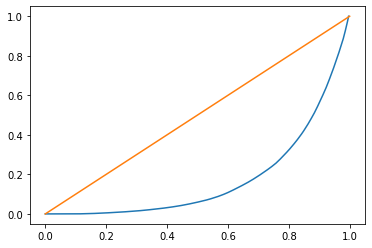

0.653589502016


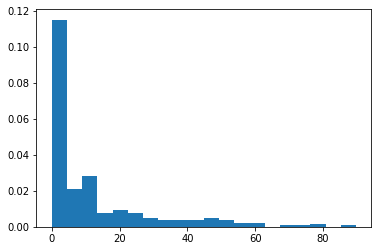

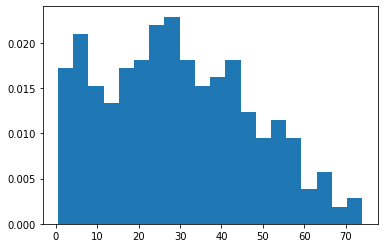

In [57]:
a.lorentz_curve()
print(a.gini())
alive_wealth_histogram(a)
alive_age_histogram(a)

In [63]:

size = 30
a = Environment(size,100)
a.init_agents()

a.birth_rate = 0.009

a.step_for_resources = 1

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 4

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 2
a.variance_sugar_production_per_square = 3
a.max_produtivity = 20
a.sazonality_amplitude = 0
a.sazonality_period = 40
a.depreciation = 0.5
a.depreciation_percentage = 0.5


a.inheritance_tax = 1

a.MPC = 0

a.step()



## Evolução dos agregados
print_step = 1
pp = ProgressPlot(line_names=["agents", "+sugar","poverty","GDP","Gini","unemployment"])
# pp = ProgressPlot(line_names=["+sugar","GDP","unemployment","total sugar"])  

c_agents =0
c_production = 0
c_current_accumulation_capacity = 0
c_gini = 0
c_resouces = 0
c_hungry_agents = 0
c_current_hunger_deaths = 0
c_agents_without_production = 0
c_available_resources = 0

gini_total = []
for i in range(2000):
    c_agents +=len(a.agents)
    c_current_accumulation_capacity += a.current_accumulation_capacity
    c_gini += a.gini()
    gini_total += [a.gini()]
    c_hungry_agents += a.hungry_agents
    c_current_hunger_deaths += a.current_hunger_deaths
    
    c_resouces += a.sum_of_new_resources
    c_available_resources += a.available_resources
    c_production += a.current_production
    c_agents_without_production += a.agents_without_production
    if i%print_step == 0:
        c_agents = (1/1)*c_agents/print_step
        c_agents_without_production = (1/1)*c_agents_without_production/print_step
        c_hungry_agents =(1/1)*c_hungry_agents/print_step
        c_gini = (1000)*c_gini/print_step

        
        c_current_accumulation_capacity = (1/100)*(c_current_accumulation_capacity/(print_step))
        c_resouces = (1/10)*(c_resouces/(print_step*2))
        c_production = (c_production/(print_step))/2
        c_available_resources = (1/10)*c_available_resources/(print_step)

        c_current_hunger_deaths = c_current_hunger_deaths/print_step
        
        
        ##População
        pp.update([[c_agents,c_resouces,c_hungry_agents,c_production,c_gini,c_agents_without_production]])
        
        ##Producao
#         pp.update([[c_resouces,c_production,c_agents_without_production,c_available_resources]])

        print(c_agents)
            
            
        c_agents = 0
        c_production = 0
        c_current_accumulation_capacity = 0
        c_gini = 0
        c_resouces = 0
        c_hungry_agents = 0
        c_current_hunger_deaths = 0
        c_agents_without_production = 0
        c_available_resources = 0
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)








101.0
102.0
102.0
106.0
109.0
110.0
113.0
113.0
115.0
116.0
119.0
120.0
121.0
122.0
124.0
125.0
125.0
126.0
128.0
128.0
128.0
132.0
134.0
137.0
138.0
140.0
142.0
143.0
144.0
147.0
148.0
150.0
153.0
155.0
160.0
163.0
164.0
166.0
169.0
172.0
175.0
177.0
177.0
179.0
179.0
179.0
180.0
182.0
186.0
187.0
190.0
192.0
195.0
196.0
196.0
198.0
199.0
201.0
204.0
206.0
208.0
210.0
212.0
213.0
216.0
218.0
220.0
224.0
224.0
231.0
234.0
236.0
238.0
239.0
241.0
243.0
245.0
248.0
249.0
250.0
252.0
254.0
257.0
259.0
262.0
262.0
264.0
266.0
268.0
272.0
274.0
274.0
277.0
280.0
282.0
288.0
289.0
294.0
299.0
301.0
303.0
306.0
309.0
309.0
314.0
317.0
317.0
322.0
325.0
326.0
328.0
332.0
333.0
334.0
336.0
340.0
343.0
343.0
343.0
347.0
347.0
348.0
355.0
358.0
359.0
359.0
362.0
366.0
369.0
373.0
374.0
376.0
379.0
380.0


/Users/kauemoraes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:371: RuntimeWarning: divide by zero encountered in double_scalars


378.0
379.0
383.0
383.0
380.0
383.0
380.0
375.0


/Users/kauemoraes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:371: RuntimeWarning: invalid value encountered in double_scalars


368.0
366.0
362.0
362.0
357.0
359.0
355.0
355.0
351.0
353.0
351.0
351.0
347.0
344.0
338.0
338.0
332.0
323.0
321.0
314.0
308.0
303.0
299.0
296.0
289.0
289.0
289.0
285.0
289.0
288.0
288.0
286.0
282.0
284.0
283.0
286.0
284.0
286.0
282.0
279.0
282.0
279.0
278.0
280.0
279.0
280.0
281.0
282.0
281.0
280.0
280.0
284.0
283.0
285.0
291.0
293.0
293.0
296.0
296.0
300.0
301.0
300.0
305.0
308.0
310.0
315.0
317.0
317.0
321.0
322.0
323.0
326.0
326.0
328.0
330.0
332.0
331.0
334.0
337.0
345.0
349.0
352.0
351.0
354.0
360.0
365.0
368.0
373.0
374.0
378.0
381.0
380.0
386.0
384.0
388.0
390.0
395.0
400.0
401.0
401.0
404.0
407.0
405.0
405.0
409.0
412.0
417.0
418.0
418.0
418.0
422.0
424.0
429.0
428.0
430.0
431.0
429.0
431.0
436.0
432.0
431.0
433.0
432.0
433.0
429.0
427.0
429.0
428.0
430.0
432.0
434.0
435.0
432.0
427.0
424.0
426.0
426.0
424.0
424.0
420.0
418.0
418.0
416.0
413.0
407.0
405.0
406.0
397.0
391.0
388.0
388.0
381.0
380.0
379.0
370.0
367.0
367.0
361.0
354.0
350.0
345.0
345.0
335.0
331.0
332.0
327.0
319.

288.0
287.0
283.0
284.0
284.0
286.0
286.0
284.0
285.0
285.0
285.0
285.0
282.0
285.0
284.0
286.0
284.0
285.0
284.0
285.0
288.0
294.0
292.0
291.0
292.0
290.0
291.0
290.0
291.0
287.0
283.0
284.0
284.0
286.0
287.0
292.0
291.0
294.0
295.0
292.0
293.0
296.0
297.0
296.0
299.0
303.0
303.0
303.0
302.0
300.0
306.0
308.0
311.0
311.0
309.0
312.0
313.0
313.0
311.0
313.0
320.0
321.0
321.0
317.0
316.0
318.0
318.0
313.0
308.0
314.0
312.0
311.0
312.0
311.0
312.0
316.0
318.0
319.0
319.0
318.0
313.0
309.0
308.0
306.0
304.0
305.0
304.0
306.0
305.0
307.0
307.0
306.0
306.0
304.0
302.0
304.0
300.0
302.0
301.0
300.0
301.0
300.0
298.0
301.0
300.0
300.0
303.0
304.0
300.0
300.0
306.0
316.0
315.0
316.0
315.0
315.0
320.0
318.0
317.0
319.0
325.0
328.0
329.0
331.0
331.0
336.0
339.0
340.0
340.0
342.0
344.0
341.0
340.0
343.0
341.0
336.0
332.0
335.0
338.0
340.0
338.0
340.0
338.0
335.0
338.0
340.0
340.0
338.0
339.0
338.0
339.0
338.0
339.0
341.0
342.0
342.0
341.0
339.0
339.0
342.0
345.0
344.0
346.0
346.0
348.0
351.0
352.

In [64]:
np.mean(gini_total[500:-1]),np.var(gini_total[500:2000])

(0.69426584305003036, 0.00042995124689416937)

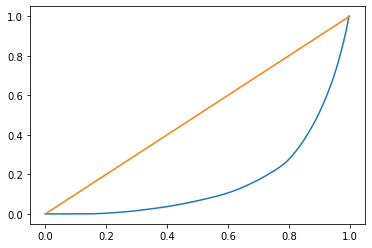

0.676360955935


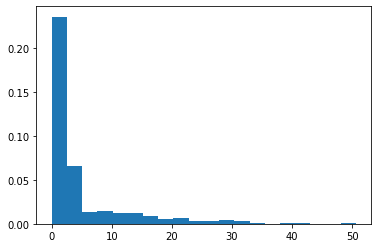

In [65]:
a.lorentz_curve()
print(a.gini())
alive_wealth_histogram(a)
alive_age_histogram(a)

# (No Tax)

In [10]:
size = 40
a = Environment(size,700)
a.init_agents()

a.birth_rate = 0.009

a.step_for_resources = 1

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 8

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 0.5
a.variance_sugar_production_per_square = 2
a.max_produtivity = 20
a.sazonality_amplitude = 0
a.sazonality_period = 40
a.depreciation = 0.5
a.depreciation_percentage = 0.8


a.inheritance_tax = 0

a.MPC = 0

a.step()



## Evolução dos agregados
print_step = 1
# pp = ProgressPlot(line_names=["agents", "+sugar","poverty","GDP","Gini","unemployment"])
pp = ProgressPlot(line_names=["+sugar","GDP","unemployment","total sugar"])  

c_agents =0
c_production = 0
c_current_accumulation_capacity = 0
c_gini = 0
c_resouces = 0
c_hungry_agents = 0
c_current_hunger_deaths = 0
c_agents_without_production = 0
c_available_resources = 0
for i in range(2000):
    c_agents +=len(a.agents)
    c_current_accumulation_capacity += a.current_accumulation_capacity
    c_gini += a.gini()
    c_hungry_agents += a.hungry_agents
    c_current_hunger_deaths += a.current_hunger_deaths
    
    c_resouces += a.sum_of_new_resources
    c_available_resources += a.available_resources
    c_production += a.current_production
    c_agents_without_production += a.agents_without_production
    if i%print_step == 0:
        c_agents = (1/1)*c_agents/print_step
        c_agents_without_production = (1/1)*c_agents_without_production/print_step
        c_hungry_agents =(1/1)*c_hungry_agents/print_step
        c_gini = (100)*c_gini/print_step

        
        c_current_accumulation_capacity = (1/100)*(c_current_accumulation_capacity/(print_step))
        c_resouces = (1/5)*(c_resouces/(print_step))
        c_production = (c_production/(print_step))/2
        c_available_resources = (1/10)*c_available_resources/(print_step)

        c_current_hunger_deaths = c_current_hunger_deaths/print_step
        
        
        ##População
#         pp.update([[c_agents,c_resouces,c_hungry_agents,c_production,c_gini,c_agents_without_production]])
        
        ##Producao
        pp.update([[c_resouces,c_production,c_agents_without_production,c_available_resources]])

        print(c_agents)
            
            
        c_agents = 0
        c_production = 0
        c_current_accumulation_capacity = 0
        c_gini = 0
        c_resouces = 0
        c_hungry_agents = 0
        c_current_hunger_deaths = 0
        c_agents_without_production = 0
        c_available_resources = 0
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)





708.0
710.0
719.0
727.0
733.0
744.0
749.0
755.0
766.0
775.0
780.0
785.0
793.0
804.0
812.0
826.0
832.0
841.0
844.0
852.0
862.0
871.0
884.0
897.0
905.0
912.0
920.0
925.0
937.0
955.0
968.0
975.0
984.0
993.0
1009.0
1019.0
1029.0
1034.0
1047.0
1058.0
1067.0
1075.0
1083.0
1090.0
1100.0
1109.0
1120.0
1129.0
1132.0
1142.0
1148.0
1158.0
1174.0
1183.0
1196.0
1208.0
1215.0
1226.0
1236.0
1246.0
1255.0
1257.0
1270.0
1277.0
1279.0
1287.0
1300.0
1301.0
1302.0
1310.0
1311.0
1314.0
1314.0
1314.0
1306.0
1303.0
1287.0
1283.0
1283.0
1272.0
1261.0
1254.0
1247.0
1232.0
1223.0
1213.0
1195.0
1178.0
1157.0
1135.0
1110.0
1095.0
1076.0
1056.0
1038.0
1028.0
1007.0
989.0
978.0
973.0
962.0
952.0
945.0
934.0
916.0
910.0
904.0
893.0
885.0
878.0
875.0
877.0
870.0
862.0
858.0
854.0
856.0
849.0
844.0
841.0
841.0
832.0
829.0
827.0
827.0
825.0
821.0
827.0
831.0
823.0
827.0
823.0
817.0
816.0
811.0
815.0
813.0
812.0
813.0
827.0
831.0
825.0
819.0
812.0
807.0
805.0
807.0
804.0
804.0
807.0
805.0
807.0
803.0
800.0
802.0
803.0
8

1012.0
1015.0
1012.0
1015.0
1018.0
1024.0
1025.0
1023.0
1027.0
1020.0
1025.0
1022.0
1018.0
1019.0
1016.0
1018.0
1017.0
1012.0
1005.0
1004.0
1012.0
1016.0
1016.0
1014.0
1011.0
1007.0
1005.0
1006.0
1012.0
1015.0
1016.0
1015.0
1013.0
1011.0
1013.0
1013.0
1010.0
1003.0
1010.0
1011.0
1015.0
1016.0
1015.0
1017.0
1012.0
1012.0
1013.0
1014.0
1013.0
1012.0
1012.0
1009.0
998.0
1001.0
1006.0
1003.0
1003.0
1010.0
1011.0
1011.0
1010.0
1009.0
1009.0
1012.0
1011.0
1006.0
1008.0
1013.0
1006.0
1012.0
1013.0
1007.0
1003.0
1003.0
1000.0
1000.0
1002.0
1012.0
1014.0
1009.0
1005.0
1008.0
1010.0
1008.0
1006.0
1007.0
1004.0
1001.0
1002.0
1004.0
1002.0
994.0
997.0
998.0
994.0
995.0
993.0
989.0
986.0
988.0
985.0
987.0
984.0
990.0
989.0
989.0
993.0
986.0
984.0
982.0
986.0
981.0
978.0
982.0
980.0
981.0
986.0
988.0
987.0
987.0
993.0
998.0
996.0
999.0
1001.0
1002.0
1000.0
998.0
997.0
996.0
997.0
999.0
997.0
1002.0
1001.0
1004.0
1011.0
1010.0
1014.0
1018.0
1021.0
1014.0
1015.0
1016.0
1017.0
1016.0
1008.0
1005.0
999.

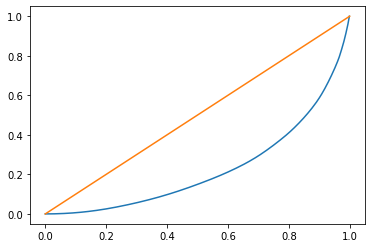

0.545451632947


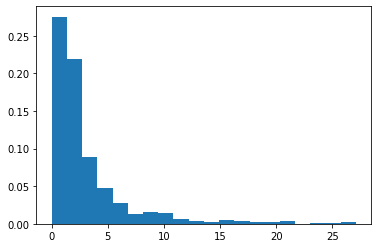

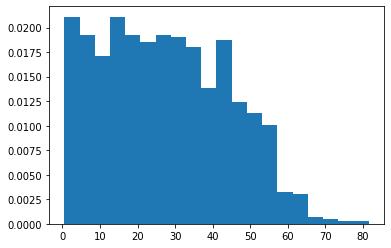

In [11]:
a.lorentz_curve()
print(a.gini())
alive_wealth_histogram(a)
alive_age_histogram(a)

In [13]:
size = 40
a = Environment(size,700)
a.init_agents()

a.birth_rate = 0.009

a.step_for_resources = 1

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 8

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 0.5
a.variance_sugar_production_per_square = 2
a.max_produtivity = 20
a.sazonality_amplitude = 0
a.sazonality_period = 40
a.depreciation = 0.5
a.depreciation_percentage = 0.8


a.inheritance_tax = 0

a.MPC = 0

a.step()



## Evolução dos agregados
print_step = 1
pp = ProgressPlot(line_names=["agents", "+sugar","poverty","GDP","Gini","unemployment"])
# pp = ProgressPlot(line_names=["+sugar","GDP","unemployment","total sugar"])  

c_agents =0
c_production = 0
c_current_accumulation_capacity = 0
c_gini = 0
c_resouces = 0
c_hungry_agents = 0
c_current_hunger_deaths = 0
c_agents_without_production = 0
c_available_resources = 0
for i in range(2000):
    c_agents +=len(a.agents)
    c_current_accumulation_capacity += a.current_accumulation_capacity
    c_gini += a.gini()
    c_hungry_agents += a.hungry_agents
    c_current_hunger_deaths += a.current_hunger_deaths
    
    c_resouces += a.sum_of_new_resources
    c_available_resources += a.available_resources
    c_production += a.current_production
    c_agents_without_production += a.agents_without_production
    if i%print_step == 0:
        c_agents = (1/1)*c_agents/print_step
        c_agents_without_production = (1/1)*c_agents_without_production/print_step
        c_hungry_agents =(1/1)*c_hungry_agents/print_step
        c_gini = (1000)*c_gini/print_step

        
        c_current_accumulation_capacity = (1/100)*(c_current_accumulation_capacity/(print_step))
        c_resouces = (1/5)*(c_resouces/(print_step))
        c_production = (c_production/(print_step))/2
        c_available_resources = (1/10)*c_available_resources/(print_step)

        c_current_hunger_deaths = c_current_hunger_deaths/print_step
        
        
        ##População
        pp.update([[c_agents,c_resouces,c_hungry_agents,c_production,c_gini,c_agents_without_production]])
        
        ##Producao
#         pp.update([[c_resouces,c_production,c_agents_without_production,c_available_resources]])

        print(c_agents)
            
            
        c_agents = 0
        c_production = 0
        c_current_accumulation_capacity = 0
        c_gini = 0
        c_resouces = 0
        c_hungry_agents = 0
        c_current_hunger_deaths = 0
        c_agents_without_production = 0
        c_available_resources = 0
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)






<IPython.core.display.Javascript object>

705.0
712.0
718.0
723.0
730.0
734.0
744.0
751.0
758.0
769.0
774.0
786.0
794.0
806.0
814.0
818.0
825.0
831.0
842.0
851.0
855.0
862.0
868.0
875.0
880.0
892.0
899.0
915.0
923.0
936.0
945.0
957.0
968.0
974.0
986.0
995.0
1003.0
1009.0
1018.0
1027.0
1044.0
1052.0
1059.0
1065.0
1075.0
1088.0
1093.0
1102.0
1112.0
1121.0
1131.0
1135.0
1139.0
1154.0
1168.0
1176.0
1188.0
1193.0
1196.0
1209.0
1212.0
1217.0
1217.0
1224.0
1231.0
1232.0
1229.0
1230.0
1225.0
1228.0
1220.0
1212.0
1214.0
1201.0
1193.0
1187.0
1178.0
1167.0
1152.0
1136.0
1119.0
1100.0
1085.0
1073.0
1051.0
1036.0
1024.0
997.0
980.0
968.0
961.0
938.0
928.0
921.0
917.0
903.0
890.0
877.0
873.0
868.0
860.0
852.0
848.0
838.0
828.0
826.0
820.0
816.0
805.0
805.0
798.0
797.0
792.0
792.0
796.0
798.0
791.0
793.0
791.0
786.0
781.0
768.0
774.0
771.0
771.0
770.0
775.0
774.0
771.0
769.0
770.0
766.0
765.0
763.0
763.0
762.0
762.0
763.0
761.0
759.0
756.0
760.0
755.0
760.0
757.0
757.0
768.0
766.0
765.0
768.0
769.0
766.0
770.0
772.0
771.0
766.0
768.0
769.0
7

996.0
995.0
997.0
999.0
990.0
987.0
986.0
984.0
990.0
990.0
987.0
983.0
987.0
992.0
993.0
996.0
997.0
1003.0
1002.0
1002.0
1007.0
1006.0
1004.0
996.0
997.0
995.0
995.0
995.0
999.0
994.0
995.0
996.0
1004.0
1008.0
1013.0
1015.0
1016.0
1015.0
1016.0
1017.0
1023.0
1021.0
1018.0
1020.0
1022.0
1015.0
1017.0
1014.0
1018.0
1016.0
1020.0
1017.0
1018.0
1015.0
1015.0
1013.0
1012.0
1011.0
1013.0
1013.0
1014.0
1019.0
1017.0
1024.0
1019.0
1008.0
1009.0
1014.0
1015.0
1013.0
1005.0
1008.0
1001.0
996.0
992.0
990.0
990.0
987.0
983.0
983.0
981.0
982.0
985.0
986.0
984.0
987.0
984.0
990.0
987.0
979.0
977.0
978.0
976.0
965.0
973.0
972.0
976.0
972.0
975.0
975.0
974.0
968.0
967.0
965.0
969.0
965.0
966.0
967.0
970.0
972.0
965.0
962.0
958.0
960.0
966.0
965.0
958.0
965.0
967.0
965.0
962.0
963.0
960.0
966.0
969.0
969.0
966.0
971.0
979.0
982.0
981.0
981.0
981.0
979.0
981.0
982.0
982.0
975.0
973.0
970.0
972.0
973.0
981.0
976.0
975.0
975.0
974.0
970.0
974.0
969.0
966.0
962.0
969.0
968.0
967.0
969.0
967.0
972.0
974.0

KeyboardInterrupt: 

# inheritance tax = 0.5

In [14]:
size = 40
a = Environment(size,700)
a.init_agents()

a.birth_rate = 0.009

a.step_for_resources = 1

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 8

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 0.5
a.variance_sugar_production_per_square = 2
a.max_produtivity = 20
a.sazonality_amplitude = 0
a.sazonality_period = 40
a.depreciation = 0.5
a.depreciation_percentage = 0.8


a.inheritance_tax = 0.5

a.MPC = 0

a.step()



## Evolução dos agregados
print_step = 1
pp = ProgressPlot(line_names=["agents", "+sugar","poverty","GDP","Gini","unemployment"])
# pp = ProgressPlot(line_names=["+sugar","GDP","unemployment","total sugar"])  

c_agents =0
c_production = 0
c_current_accumulation_capacity = 0
c_gini = 0
c_resouces = 0
c_hungry_agents = 0
c_current_hunger_deaths = 0
c_agents_without_production = 0
c_available_resources = 0
for i in range(2000):
    c_agents +=len(a.agents)
    c_current_accumulation_capacity += a.current_accumulation_capacity
    c_gini += a.gini()
    c_hungry_agents += a.hungry_agents
    c_current_hunger_deaths += a.current_hunger_deaths
    
    c_resouces += a.sum_of_new_resources
    c_available_resources += a.available_resources
    c_production += a.current_production
    c_agents_without_production += a.agents_without_production
    if i%print_step == 0:
        c_agents = (1/1)*c_agents/print_step
        c_agents_without_production = (1/1)*c_agents_without_production/print_step
        c_hungry_agents =(1/1)*c_hungry_agents/print_step
        c_gini = (1000)*c_gini/print_step

        
        c_current_accumulation_capacity = (1/100)*(c_current_accumulation_capacity/(print_step))
        c_resouces = (1/5)*(c_resouces/(print_step))
        c_production = (c_production/(print_step))/2
        c_available_resources = (1/10)*c_available_resources/(print_step)

        c_current_hunger_deaths = c_current_hunger_deaths/print_step
        
        
        ##População
        pp.update([[c_agents,c_resouces,c_hungry_agents,c_production,c_gini,c_agents_without_production]])
        
        ##Producao
#         pp.update([[c_resouces,c_production,c_agents_without_production,c_available_resources]])

        print(c_agents)
            
            
        c_agents = 0
        c_production = 0
        c_current_accumulation_capacity = 0
        c_gini = 0
        c_resouces = 0
        c_hungry_agents = 0
        c_current_hunger_deaths = 0
        c_agents_without_production = 0
        c_available_resources = 0
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)







<IPython.core.display.Javascript object>

706.0
711.0
720.0
728.0
735.0
744.0
748.0
752.0
763.0
772.0
779.0
790.0
798.0
807.0
810.0
818.0
825.0
831.0
835.0
843.0
850.0
858.0
867.0
877.0
882.0
889.0
897.0
903.0
908.0
917.0
927.0
937.0
945.0
949.0
960.0
970.0
977.0
985.0
991.0
1009.0
1022.0
1030.0
1039.0
1050.0
1059.0
1066.0
1078.0
1083.0
1097.0
1109.0
1120.0
1130.0
1143.0
1153.0
1165.0
1166.0
1175.0
1181.0
1188.0
1206.0
1210.0
1213.0
1218.0
1216.0
1215.0
1215.0
1219.0
1219.0
1213.0
1218.0
1214.0
1207.0
1202.0
1185.0
1167.0
1161.0
1150.0
1148.0
1128.0
1106.0
1092.0
1081.0
1062.0
1053.0
1035.0
1011.0
995.0
973.0
959.0
948.0
930.0
914.0
898.0
889.0
880.0
871.0
863.0
859.0
852.0
852.0
847.0
840.0
836.0
830.0
829.0
826.0
822.0
812.0
803.0
806.0
807.0
800.0
799.0
797.0
794.0
792.0
795.0
791.0
788.0
789.0
794.0
795.0
800.0
803.0
803.0
800.0
804.0
805.0
808.0
806.0
805.0
803.0
797.0
800.0
809.0
806.0
806.0
803.0
800.0
805.0
807.0
809.0
802.0
803.0
804.0
806.0
799.0
802.0
801.0
804.0
804.0
803.0
801.0
803.0
805.0
808.0
812.0
813.0
808.0

1043.0
1043.0
1042.0
1039.0
1035.0
1031.0
1032.0
1039.0
1038.0
1039.0
1036.0
1035.0
1041.0
1041.0
1038.0
1033.0
1030.0
1038.0
1034.0
1035.0
1031.0
1029.0
1035.0
1042.0
1044.0
1043.0
1048.0
1049.0
1048.0
1048.0
1045.0
1048.0
1047.0
1038.0
1032.0
1028.0
1028.0
1016.0
1014.0
1021.0
1022.0
1030.0
1030.0
1034.0
1028.0
1033.0
1037.0
1035.0
1039.0
1035.0
1028.0
1031.0
1026.0
1035.0
1037.0
1037.0
1042.0
1038.0
1039.0
1042.0
1043.0
1040.0
1042.0
1049.0
1046.0
1044.0
1048.0
1043.0
1047.0
1046.0
1050.0
1040.0
1040.0
1042.0
1048.0
1048.0
1047.0
1051.0
1046.0
1041.0
1043.0
1032.0
1029.0
1027.0
1030.0
1033.0
1025.0
1017.0
1016.0
1024.0
1028.0
1033.0
1042.0
1045.0
1046.0
1047.0
1043.0
1050.0
1045.0
1043.0
1042.0
1042.0
1041.0
1045.0
1050.0
1050.0
1062.0
1065.0
1062.0
1062.0
1060.0
1067.0
1069.0
1069.0
1068.0
1063.0
1061.0
1063.0
1070.0
1074.0
1070.0
1063.0
1060.0
1059.0
1062.0
1065.0
1060.0
1058.0
1064.0
1073.0
1072.0
1070.0
1070.0
1066.0
1064.0
1063.0
1063.0
1059.0
1062.0
1063.0
1066.0
1060.0
1056.0

KeyboardInterrupt: 

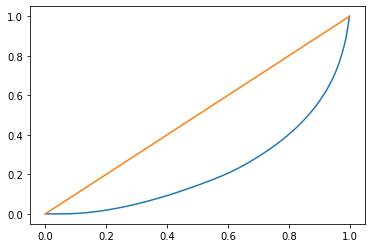

0.560759442047


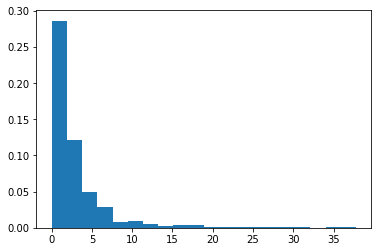

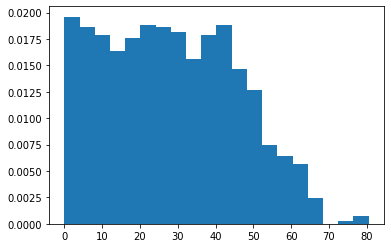

In [15]:
a.lorentz_curve()
print(a.gini())
alive_wealth_histogram(a)
alive_age_histogram(a)

# Inheritance Tax = 0.5 and bigger variance

In [16]:
size = 40
a = Environment(size,700)
a.init_agents()

a.birth_rate = 0.009

a.step_for_resources = 1

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 8

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 0.5
a.variance_sugar_production_per_square = 5
a.max_produtivity = 20
a.sazonality_amplitude = 0
a.sazonality_period = 40
a.depreciation = 0.5
a.depreciation_percentage = 0.8


a.inheritance_tax = 0.5

a.MPC = 0

a.step()



## Evolução dos agregados
print_step = 1
pp = ProgressPlot(line_names=["agents", "+sugar","poverty","GDP","Gini","unemployment"])
# pp = ProgressPlot(line_names=["+sugar","GDP","unemployment","total sugar"])  

c_agents =0
c_production = 0
c_current_accumulation_capacity = 0
c_gini = 0
c_resouces = 0
c_hungry_agents = 0
c_current_hunger_deaths = 0
c_agents_without_production = 0
c_available_resources = 0
for i in range(2000):
    c_agents +=len(a.agents)
    c_current_accumulation_capacity += a.current_accumulation_capacity
    c_gini += a.gini()
    c_hungry_agents += a.hungry_agents
    c_current_hunger_deaths += a.current_hunger_deaths
    
    c_resouces += a.sum_of_new_resources
    c_available_resources += a.available_resources
    c_production += a.current_production
    c_agents_without_production += a.agents_without_production
    if i%print_step == 0:
        c_agents = (1/1)*c_agents/print_step
        c_agents_without_production = (1/1)*c_agents_without_production/print_step
        c_hungry_agents =(1/1)*c_hungry_agents/print_step
        c_gini = (1000)*c_gini/print_step

        
        c_current_accumulation_capacity = (1/100)*(c_current_accumulation_capacity/(print_step))
        c_resouces = (1/5)*(c_resouces/(print_step))
        c_production = (c_production/(print_step))/2
        c_available_resources = (1/10)*c_available_resources/(print_step)

        c_current_hunger_deaths = c_current_hunger_deaths/print_step
        
        
        ##População
        pp.update([[c_agents,c_resouces,c_hungry_agents,c_production,c_gini,c_agents_without_production]])
        
        ##Producao
#         pp.update([[c_resouces,c_production,c_agents_without_production,c_available_resources]])

        print(c_agents)
            
            
        c_agents = 0
        c_production = 0
        c_current_accumulation_capacity = 0
        c_gini = 0
        c_resouces = 0
        c_hungry_agents = 0
        c_current_hunger_deaths = 0
        c_agents_without_production = 0
        c_available_resources = 0
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)








<IPython.core.display.Javascript object>

704.0
711.0
719.0
727.0
733.0
740.0
748.0
756.0
763.0
770.0
775.0
779.0
790.0
798.0
810.0
819.0
834.0
842.0
852.0
865.0
877.0
890.0
902.0
915.0
927.0
934.0
949.0
961.0
968.0
975.0
984.0
994.0
1006.0
1023.0
1031.0
1039.0
1040.0
1050.0
1058.0
1068.0
1080.0
1086.0
1093.0
1103.0
1113.0
1121.0
1134.0
1141.0
1151.0
1162.0
1169.0
1180.0
1191.0
1202.0
1216.0
1226.0
1236.0
1247.0
1259.0
1268.0
1278.0
1290.0
1300.0
1308.0
1325.0
1338.0
1346.0
1360.0
1367.0
1378.0
1394.0
1410.0
1422.0
1434.0
1447.0
1459.0
1474.0
1482.0
1500.0
1513.0
1525.0
1532.0
1547.0
1563.0
1575.0
1586.0
1596.0
1607.0


KeyboardInterrupt: 

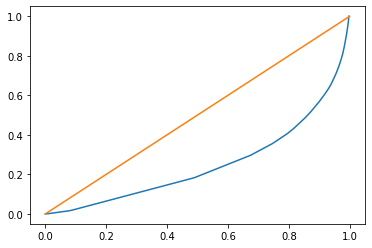

0.502443436582


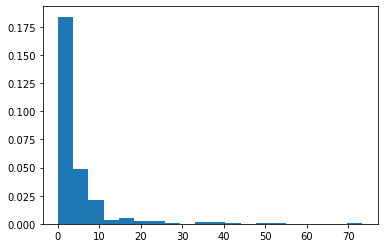

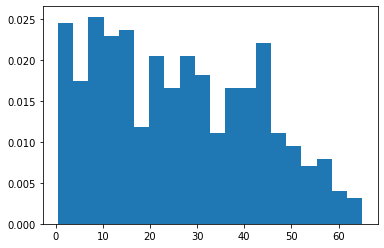

In [72]:
a.lorentz_curve()
print(a.gini())
alive_wealth_histogram(a)
alive_age_histogram(a)

# Inheritance tax = 1

In [42]:
size = 50
a = Environment(size,100)
a.init_agents()

a.birth_rate = 0.01

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 10

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 3     
a.sazonality_amplitude = 0
a.sazonality_period = 20
a.depreciation = 1
a.depreciation_percentage = 1

a.inheritance_tax = 1

a.step()



## Evolução dos agregados

pp = ProgressPlot(line_names=["agents", "sugar","fome","GDP","Prod_capa","Gini"])  
c_agents =0
c_production = 0
c_production_capacity = 0
c_gini = 0
c_resouces = 0
c_hungry_agents = 0
for i in range(2000):
    c_agents +=len(a.agents)
    c_production += a.current_production
    c_production_capacity += a.current_production_capacity
    c_gini += a.gini()
    c_resouces += np.sum(a.grid_resources)
    c_hungry_agents += a.hungry_agents
    if i%10 == 0:
        pp.update([[c_agents/10,c_resouces/50,c_hungry_agents/10,c_production/10,c_production_capacity/100,1000*a.gini()]])
        c_agents = 0
        c_production = 0
        c_production_capacity = 0
        c_gini = 0
        c_resouces = 0
        c_hungry_agents = 0
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)





gdp:  492.0
production capacity:  1200


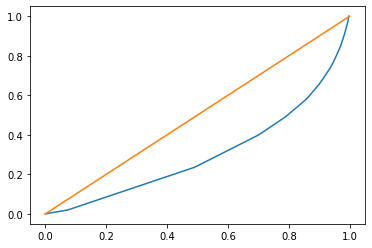

0.397589628912


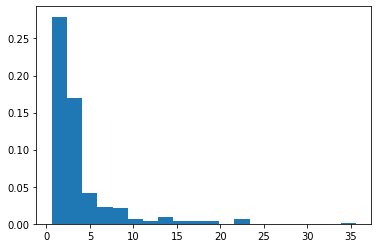

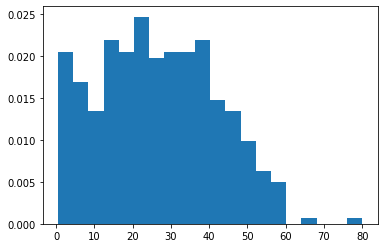

In [43]:
a.lorentz_curve()
print(a.gini())
alive_wealth_histogram(a)
alive_age_histogram(a)

In [67]:
a = Environment(50,100,step_for_resources=5)
a.max_sugar_production = 1000
a.init_agents()
a.birth_rate = 0.015
pp = ProgressPlot(line_names=["agents", "sugar stock","Gini Index"])

for i in range(400):
    a.step()
    if i%10 == 0:
        print(len(a.agents))
        pp.update([[len(a.agents),np.sum(a.grid_resources)/10,a.gini()*100]])
    
pp.finalize()

103
118
133
155
178
208
193
145
147
153
165
157
149
147
163
160
145
141
141
150
127
119
119
123
136
130
130
129
136
127
117
119
133
128
123
118
110
107
100
101


In [84]:
a = Environment(10,1,step_for_resources=3)

a.cluster_n = 2
a.cluster_size = 2
a.cluster_renew_time = 4

a.random_points_number = 2

a.mean_sugar_production_per_square = 2

a.init_agents()
for i in range(100):
    time.sleep(3)
    clear_output(wait=True)
    a.pmapa()
    a.step()

  0  	   0  	   0  	   0  	   0  	   1  	   0  	   0  	   0  	   0  	 
  0  	   0  	   2  	   2  	   0  	   0  	   0  	   0  	   0  	   6  	 
  0  	   0  	   0  	   2  	   7  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   2  	   1  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	 
  0  	 ( 0 )	   0  	   4  	   7  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   1  	   3  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	 


KeyboardInterrupt: 

In [17]:
size = 200
a = Environment(size,1000)
a.init_agents()

a.birth_rate = 0.01

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 10

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 3     
a.sazonality_amplitude = 0
a.sazonality_period = 20
a.depreciation = 1

a.inheritance_tax = 0

a.step()



## Evolução dos agregados

pp = ProgressPlot(line_names=["agents", "sugar stock","Fome","GDP","Production_capacity"])   
for i in range(1200):
    if i%10 == 0:
        pp.update([[np.sum(a.grid_resources)/10000,a.hungry_agents/100,a.current_production/100,a.current_production_capacity/100]])
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)




<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [37]:
len(a.dead_agents)

1601

In [28]:
%%matplotlib inside

ERROR:root:Cell magic `%%matplotlib` not found (But line magic `%matplotlib` exists, did you mean that instead?).


In [41]:
y =[]
for i in a.dead_agents:
    y += [len(i.children)]
    